In [24]:
import os

In [25]:
os.chdir("/kaggle/input/indian-monuments-image-dataset/Indian-monuments/images")

In [26]:
os.getcwd()

'/kaggle/input/indian-monuments-image-dataset/Indian-monuments/images'

In [27]:
train_dir='train'
test_dir='test'

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=30.0,
    zca_whitening=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split=0.2 
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=30.0,
    zca_whitening=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
)


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1054: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(


In [30]:
train=train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(160,160),
    class_mode='categorical',
    subset='training' 
)
test=test_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(160,160),
    class_mode='categorical',
    shuffle=False
)

val=train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(160,160),
    class_mode='categorical',
    subset='validation'
)


Found 2942 images belonging to 24 classes.
Found 1049 images belonging to 24 classes.
Found 724 images belonging to 24 classes.


In [31]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential()
    model.add(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(160, 160, 3)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())  # Added Batch Normalization
    model.add(Dropout(0.5))
    model.add(Dense(24, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [38]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)



In [40]:

history = model.fit(
    train,
    validation_data=val,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 681ms/step - accuracy: 0.6899 - loss: 1.0859 - val_accuracy: 0.0677 - val_loss: 3.2599
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 627ms/step - accuracy: 0.8400 - loss: 0.5581 - val_accuracy: 0.0691 - val_loss: 3.3329
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 608ms/step - accuracy: 0.8789 - loss: 0.4315 - val_accuracy: 0.0635 - val_loss: 3.3957
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 609ms/step - accuracy: 0.9122 - loss: 0.3349 - val_accuracy: 0.2541 - val_loss: 2.9619
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 610ms/step - accuracy: 0.9078 - loss: 0.3076 - val_accuracy: 0.2638 - val_loss: 3.0752
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 600ms/step - accuracy: 0.9272 - loss: 0.2398 - val_accuracy: 0.6837 - val_loss: 1.2938
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 603ms/step - accuracy: 0.9352 - loss: 0.2335 - val_accuracy: 0.6851 - val_loss: 1.3159
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 605ms/step - accuracy: 0.9337 - loss: 0.2342 - val_accu

In [41]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 518ms/step - accuracy: 0.5448 - loss: 6.1387
Test Loss: 6.517634391784668
Test Accuracy: 0.5100095272064209


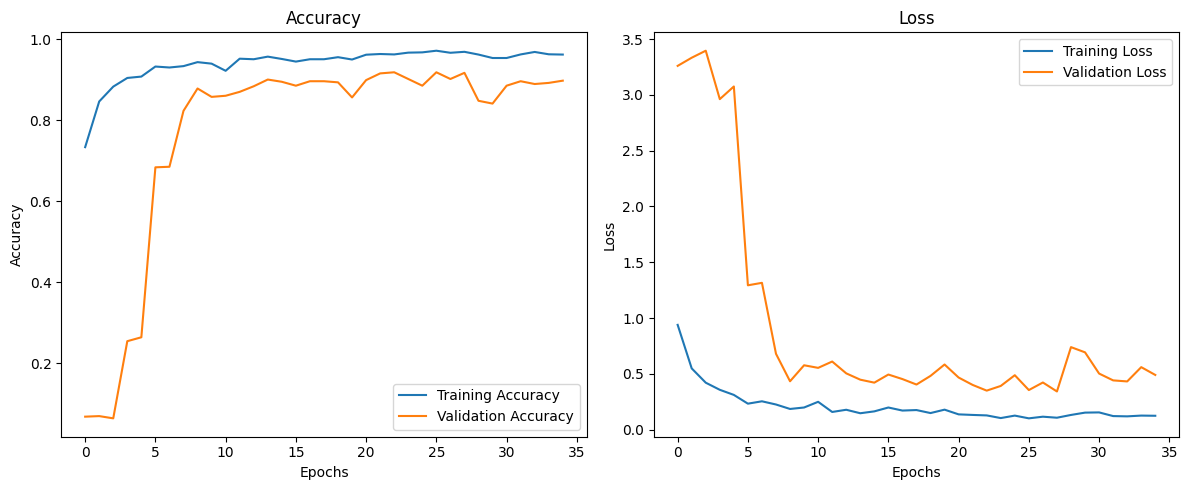

In [43]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


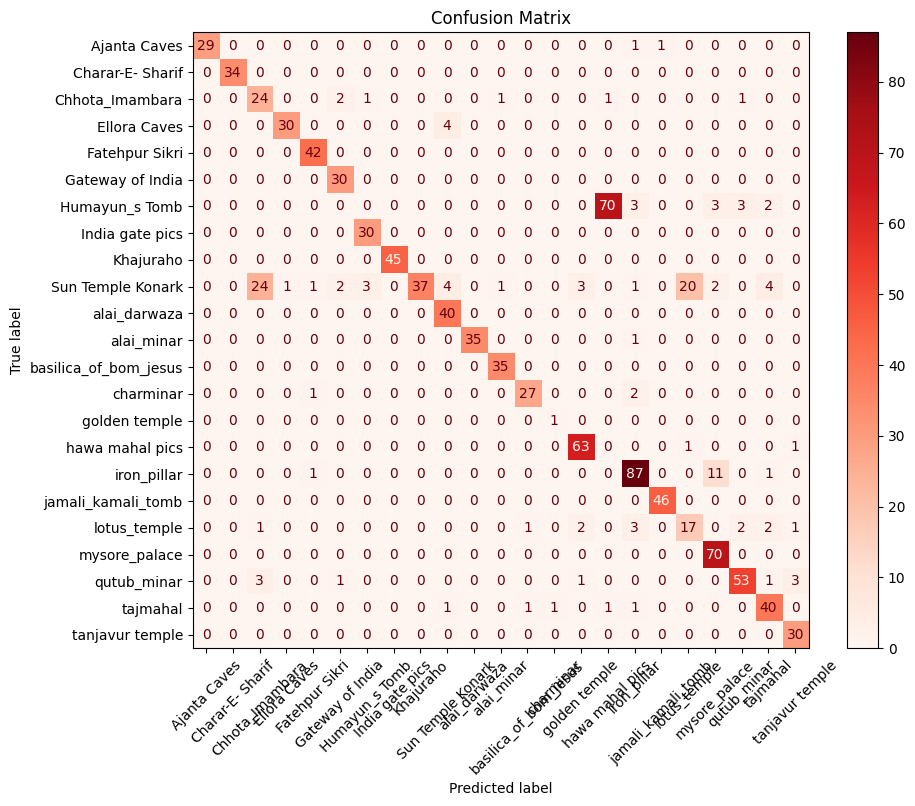

In [51]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Adjust class names to match the confusion matrix shape
n_classes = cm.shape[0]
if len(class_names) != n_classes:
    print(f"Warning: Adjusting class names to match {n_classes} classes.")
    class_names = class_names[:n_classes]

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_display.plot(cmap='Reds', ax=plt.gca())
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()


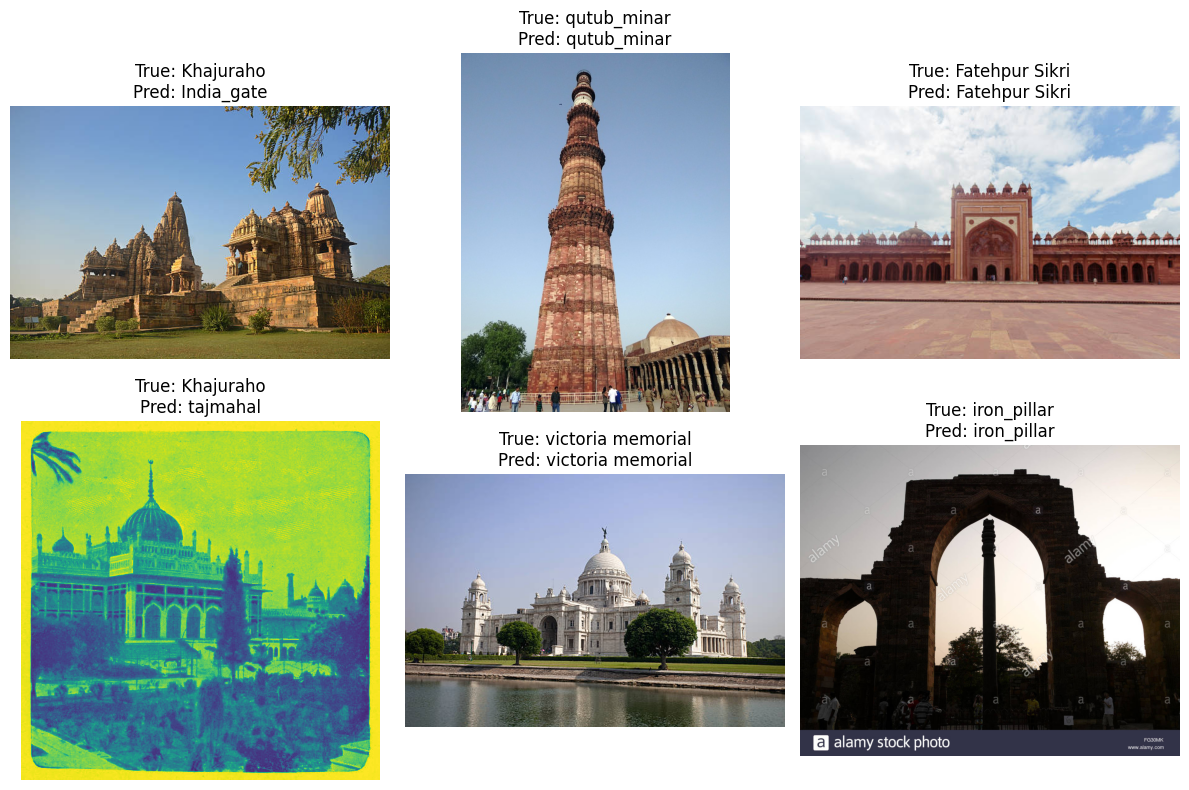

In [52]:
import random
import matplotlib.pyplot as plt

# Get 6 random indices from the test dataset
random_indices = random.sample(range(len(test.filenames)), 6)

# Prepare to display the images
plt.figure(figsize=(12, 8))

for i, index in enumerate(random_indices):
    # Load the image
    img_path = os.path.join(test_dir, test.filenames[index])
    img = plt.imread(img_path)
    
    # Get the actual label
    actual_label = test.classes[index]
    actual_label_name = list(test.class_indices.keys())[actual_label]
    
    # Get the model's prediction for this image
    model_prediction = Y_pred[index]
    predicted_label = np.argmax(model_prediction)
    predicted_label_name = list(test.class_indices.keys())[predicted_label]

    # Display the image
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f'True: {actual_label_name}\nPred: {predicted_label_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:


# Set up mirrored strategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Load EfficientNetB7
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

    # Build the model
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())

    # Adding Dense Layers
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer (assuming 24 classes)
    model.add(Dense(24, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])





258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [10]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:

# Callbacks for better training control
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [13]:
# Model Training (Assuming train_generator and validation_generator are defined)
history = model.fit(
    train,
    validation_data=val,
    epochs=200,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.0633 - loss: 3.9235 - val_accuracy: 0.0580 - val_loss: 3.3613 - learning_rate: 1.0000e-04
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 879ms/step - accuracy: 0.1834 - loss: 3.2231 - val_accuracy: 0.0387 - val_loss: 3.4828 - learning_rate: 1.0000e-04
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 876ms/step - accuracy: 0.3701 - loss: 2.3299 - val_accuracy: 0.0539 - val_loss: 3.4279 - learning_rate: 1.0000e-04
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 893ms/step - accuracy: 0.4958 - loss: 1.8835 - val_accuracy: 0.1644 - val_loss: 3.0586 - learning_rate: 1.0000e-04
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 885ms/step - accuracy: 0.5961 - loss: 1.4393 - val_accuracy: 0.3135 - val_loss: 2.4597 - learning_rate: 1.0000e-04
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 884ms/step - accuracy: 0.6782 - loss: 1.1572 - val_accuracy: 0.4986 - val_loss: 1.7636 - learning_rate: 1.0000e-04
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 887ms/step 

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 703ms/step - accuracy: 0.5533 - loss: 4.4958
Test Loss: 4.66874361038208
Test Accuracy: 0.5262154340744019


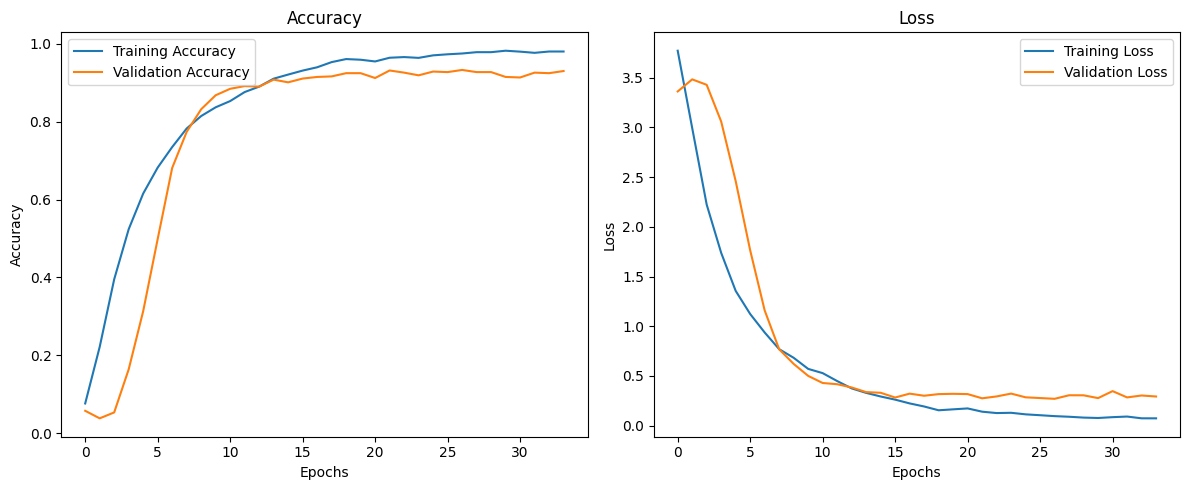

In [15]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1286: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 481ms/step


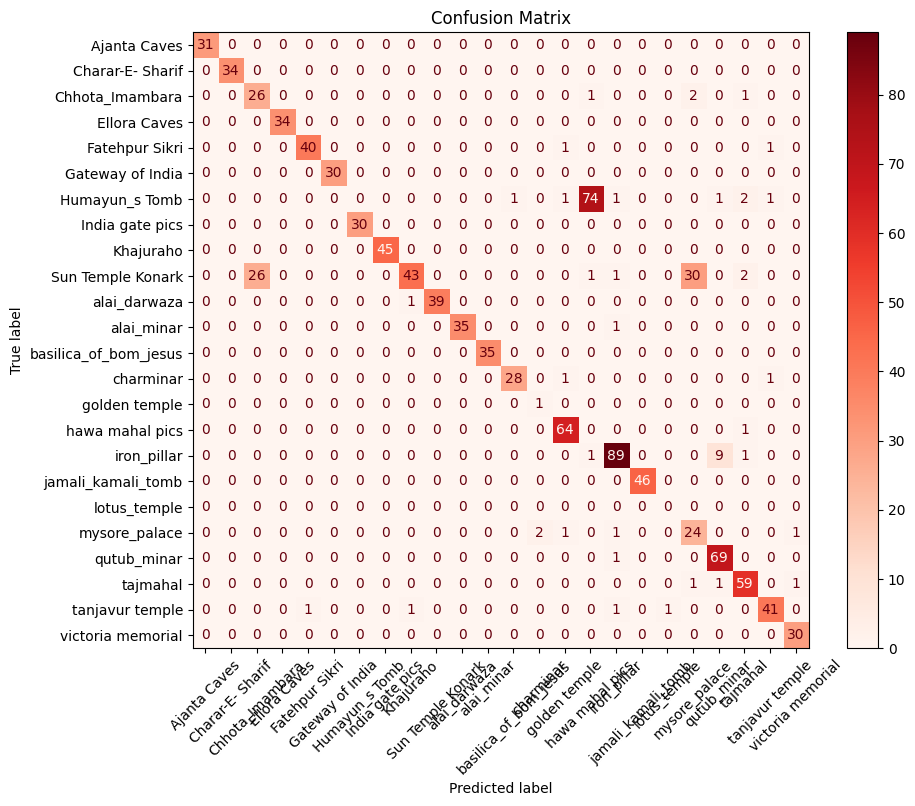

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you already have y_true and y_pred
y_true = test.classes
y_pred = np.argmax(model.predict(test), axis=1)

# Get class names from your training generator
class_names = list(train.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_display.plot(cmap='Reds', ax=plt.gca())
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()


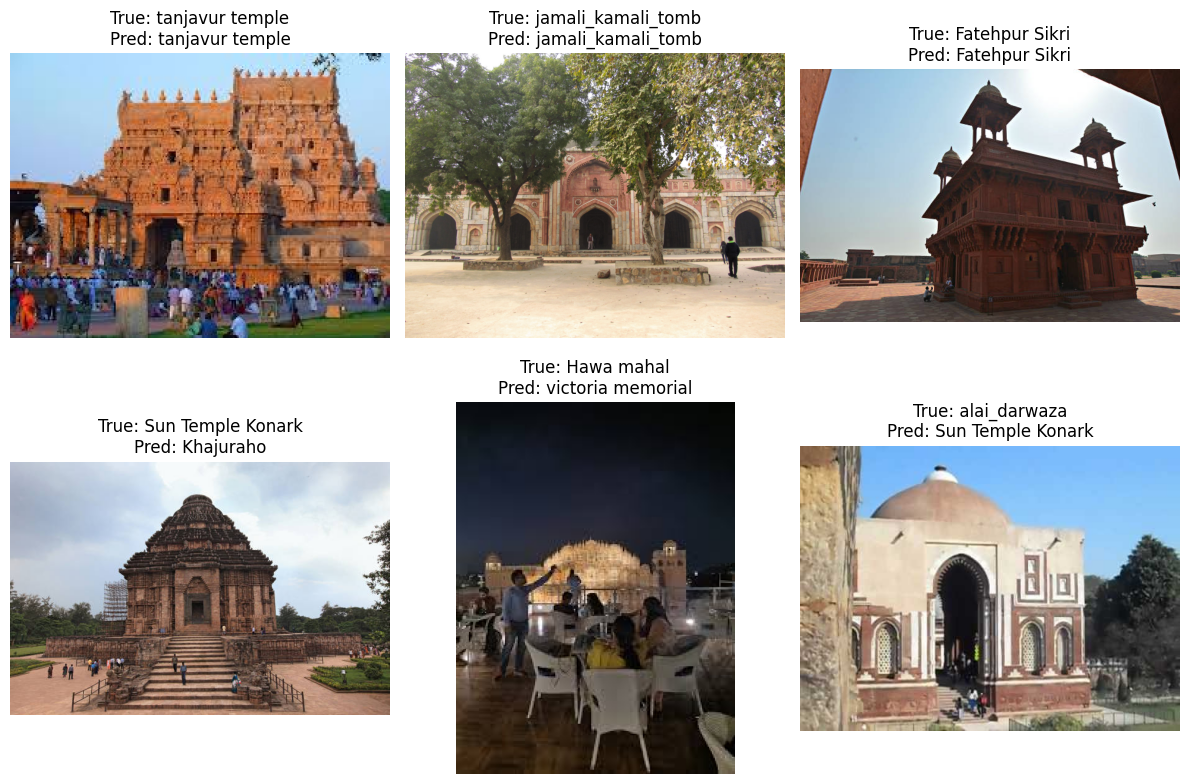

In [20]:
import random
import matplotlib.pyplot as plt

# Get 6 random indices from the test dataset
random_indices = random.sample(range(len(test.filenames)), 6)

# Prepare to display the images
plt.figure(figsize=(12, 8))

for i, index in enumerate(random_indices):
    # Load the image
    img_path = os.path.join(test_dir, test.filenames[index])
    img = plt.imread(img_path)
    
    # Get the actual label
    actual_label = test.classes[index]
    actual_label_name = list(test.class_indices.keys())[actual_label]
    
    # Get the model's prediction for this image
    model_prediction = Y_pred[index]
    predicted_label = np.argmax(model_prediction)
    predicted_label_name = list(test.class_indices.keys())[predicted_label]

    # Display the image
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f'True: {actual_label_name}\nPred: {predicted_label_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()
